<a target="_blank" href="https://colab.research.google.com/github/felicebenita99/Data-Science/blob/main/myproject-ipynb/Customer_Segmentation_in_Python_Using_K-Means_and_PCA.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

<h2 align="center">Customer Segmentation in Python Using K-Means and PCA</h2>

<span style="font-size:17px; color:#818181; font-weight:bold">Implementing K-Means clustering algorithm and using PCA for customer segmentation in Python and interpreting results.</span>

#### <ins>Created by: Felice Benita</ins>

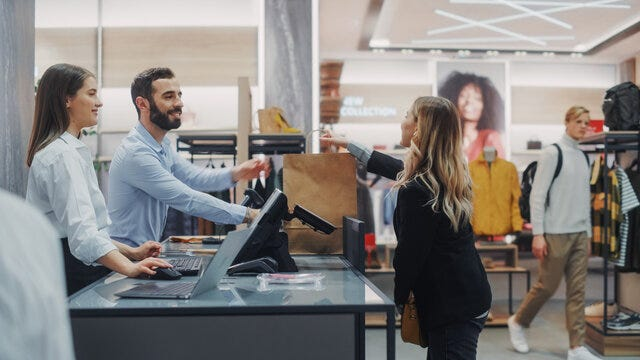

## Introduction
---

<span style="font-size:15px; color:#333;">Customer segmentation is the grouping of customers with similar characteristics like age, industry, gender, spending habits, etc. Customer segmentation is important for business to understand their customers, meet their unique needs, and grow their business. Marketing, service, and sales efforts can be personalized easily to the needs of specific groups that lead to more effective marketing, increased customer loyalty and conversions, and developing uniquely appealing products and services.<br/>
I want to demonstrate the implementation of K-Means++ clustering algorithm using PCA to create better customer segments on mall customer datasets.<br/></span>

### K-Means Clustering
<span style="font-size:15px; color:#333;">Customer segmentation is one of the applications of clustering techniques, is an unsupervised machine learning method that groups the unlabeled dataset based on their similarity and assigns them to clusters.<br/>
There are different types of clustering algorithms, we will use the K-Means algorithm, the most commonly used algorithm for customer segmentation.<br/>
K-Means clustering is an unsupervised machine learning algorithm that divides the unlabeled dataset into the given number of clusters. Here, the "K" is the given number of predefined clusters, that need to be created.<br/>
The main idea of K-Means is to reduce the distance between the data points and their respective cluster centroid.<br/>

### K-Means++
<span style="font-size:15px; color:#333;">K-Means can result in arbitrarily bad clusters if the initialization of clusters is not appropriate.<br/>
K-Means++ is a smart centroid initialization technique. Using the K-Means++ algorithm to optimize the step where we randomly pick the cluster centroid and improves the quality of the clustering.<br/>
In this project, we will use the K-Means++ algorithm to produce better clustering quality.<br/>
You can download the dataset [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python).
</span>  
</span>

## Retrieving Data
---

First, let's import the necessary libraries and read the dataset:

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

Now, let's take a look at the information of the data:

In [2]:
# Reading data
df = pd.read_csv('D:/Pedoman/Portfolio/Data Science/Customer Segmentation/Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
# Look at the dimension of the data
print(f'Data contain {df.shape[0]} records and {df.shape[1]} columns.')

Data contain 200 records and 5 columns.


There are a total of 200 records with 5 variables in the customer data.

## Data Wrangling
---

'CustomerID' is the unique identifier of each customer in the dataset, and we can drop this variable. It doesn't provide any information to build clusters.

In [4]:
# Drop unused columns
df = df.drop('CustomerID', axis=1)

Let's check the number of missing values in each variable:

In [5]:
# Check the number of missing values in each column
df.isna().sum()

Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There are no missing values ​​for each variable, so we don't need to do data wrangling.

Identified unique values ​​of each variable to separate the type of each variable:

In [6]:
# Check the unique values
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
df_uniques

,Unique Values
Variable,
Gender,2
Age,51
Annual Income (k$),64
Spending Score (1-100),84


Keep a copy the cleaned dataset:

In [7]:
# Keep a copy our cleaned data
cleaned_data = df.copy()

## Feature Engineering
---

We will separate the type of each variable:

In [8]:
# Get the binary variables
binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
binary_variables

['Gender']

'Gender' is a binary variable, a categorical variable that has binary values because it only has two unique values.

##### There are no ordinal variables and categorical variables.

In [9]:
# Get the numerical variables
numeric_variables = list(set(df.columns) - set(binary_variables))
numeric_variables = [i for i in numeric_variables]
numeric_variables

['Spending Score (1-100)', 'Age', 'Annual Income (k$)']

We can see here that there are 3 numerical variables.<br/>
'Gender' is a categorical variable and has binary values, it needs to be encoded and transformed into numeric.<br/>
The other three variables are numerical variables, so we need to detect and handle outliers. Then scaled these variables to standard normal variables, that rescaled these variables with a mean of 0 and a standard deviation of 1. This allows comparison of variables (continuous numeric) with different scales.

<span style="font-size:20px; color:#339; font-weight:bold">Feature Encoding</span>

First, create a new dataframe to store the feature engineering result data that will be parsed into the model.<br/>
The variable 'Gender' is a categorical variable with binary values, so we need to transform this variable to numeric using LabelBinarizer.

In [10]:
new_df = pd.DataFrame(df, columns=['Gender','Age','Annual Income (k$)','Spending Score (1-100)'])

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
for column in binary_variables:
    new_df[column] = lb.fit_transform(df[column])

Now, let's take a look at the head of the data frame:

In [11]:
new_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,19,15,39
1,1,21,15,81
2,0,20,16,6
3,0,23,16,77
4,0,31,17,40


We can see that 'Gender' variable has been transformed.<br/>
For numerical variables, first, we need to detect and handle outliers, then check the distribution of data is normally distributed or not because we will use the StandardScaler to rescale the data.<br/>
The Standard Scaler assumes data is fit a Gaussian distribution (bell curved) within each feature and scales them such that the distribution is centered around 0, with a standard deviation of 1.

<span style="font-size:20px; color:#339; font-weight:bold">Detecting Outliers: Visualization</span>

We will use visualization to find outliers with boxplot and use histogram to see the distribution of data.

<Axes: xlabel='Spending Score (1-100)'>

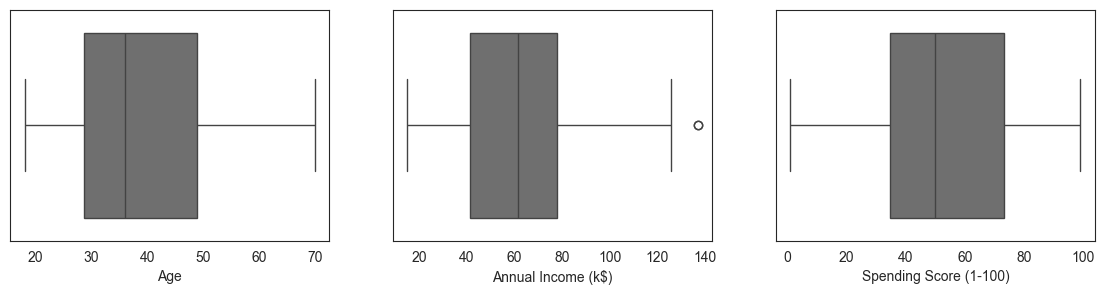

In [12]:
sns.set_style('white')

fig, axs = plt.subplots(1, 3, figsize=(14, 3))
sns.boxplot(data=new_df, x='Age', color='#6F6F6F', ax=axs[0])
sns.boxplot(data=new_df, x='Annual Income (k$)', color='#6F6F6F', ax=axs[1])
sns.boxplot(data=new_df, x='Spending Score (1-100)', color='#6F6F6F', ax=axs[2])

#### We see here that there are outliers in 'Annual Income (k$)'.

Now, let's see the distribution of data for each numerical variable.

array([[<Axes: title={'center': 'Spending Score (1-100)'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'Annual Income (k$)'}>, <Axes: >]],
      dtype=object)

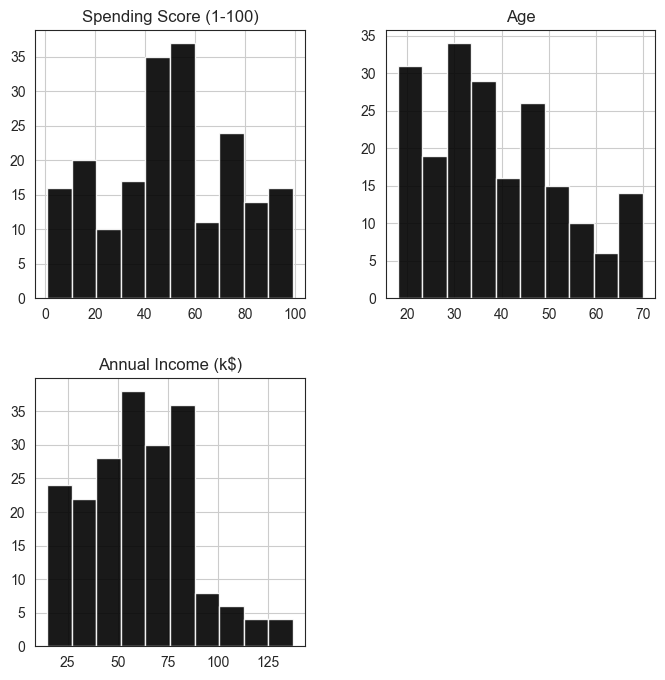

In [13]:
# Distribution of numerical variables
new_df[numeric_variables].hist(figsize=(8, 8), color='k', alpha=0.9)

Calculate and identified skewed variables, we will define a limit above 0.5 which we will log transform.

#### Skew Values

In [14]:
# Create a list of numerical variables to check for skewing
skew_limit = 0.5 # define a limit above which we will log transform
skew_vals = new_df[numeric_variables].skew()

# Showing the skewed columns
skew_cols = (skew_vals.sort_values(ascending=False).to_frame().rename(columns={0:'Skew'}).query('abs(Skew) > {}'.format(skew_limit)))
skew_cols

,Skew


The result shows that there are no skewed variables, so we don't need to log transform the variables. It shows that the data is or close to normally distributed.

<span style="font-size:20px; color:#339; font-weight:bold">Detecting Outliers: Statistics</span>

We will use mathematically to find outliers in 'Annual Income (k$)', so we're going to use np.percentile to define the 25th, 50th, and 75th percentile. Then calculate the interquartile range (iqr) and calculate the min/max limits to be considered an outlier.

In [15]:
# Calculate the interquartile range
q25, q50, q75 = np.percentile(new_df['Annual Income (k$)'], [25,50,75])
iqr = q75 - q25

# Calculate the min/max limits to be considered an outlier
min = q25 - 1.5*(iqr)
max = q75 + 1.5*(iqr)
print(min, q25, q50, q75, max)

-13.25 41.5 61.5 78.0 132.75


Anything outside either the min or the max, we count as an outlier. From boxplot, we can see that there are outliers outside the max. Now, we will identify the points, if the data point is greater than the max value then we will define that as an outlier.

In [16]:
# Identify the points
[x for x in new_df['Annual Income (k$)'] if x > max]

[137, 137]

##### We see here that there are 2 outliers in 'Annual Income (k$)' with the same value of 137.

<span style="font-size:20px; color:#339; font-weight:bold">Handling Outliers: Replace with Mean</span>

The distribution of 'Annual Income (k$)' is close to normally distributed, so we will assign the outliers with mean value.

Then, we will check the boxplot after handling the outliers.

In [17]:
# Replace outliers with mean
for row in (new_df.loc[new_df['Annual Income (k$)'] > max]).index:
    new_df.loc[row, 'Annual Income (k$)'] = new_df['Annual Income (k$)'].mean()

C:\Users\ASUSDS\AppData\Local\Temp\ipykernel_15864\3070865195.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '60.56' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  new_df.loc[row, 'Annual Income (k$)'] = new_df['Annual Income (k$)'].mean()


<Axes: xlabel='Annual Income (k$)'>

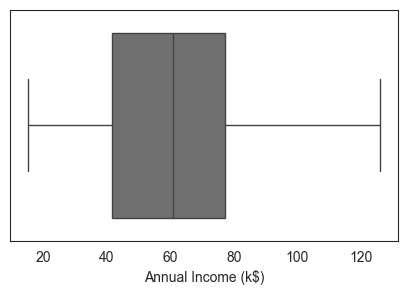

In [18]:
# Check the boxplot after handling the outliers
sns.set_style('white')
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(data=new_df, x='Annual Income (k$)', color='#6F6F6F')

##### We can see here that there are no longer outliers in 'Annual Income (k$)'.

<span style="font-size:20px; color:#339; font-weight:bold">Feature Scaling</span>

The three numerical variables data is or close to normally distributed, and there are only two outliers in 'Annual Income (k$)' that we've replaced with the mean value.<br/>
Numerical variables with different scales need to be rescaled to a fixed range. So, in this case we can use standardization that rescaled these variables with a mean of 0 and a standard deviation of 1.
Let's take a look at the all features or variables after feature engineering:

In [19]:
new_df[numeric_variables] = preprocessing.StandardScaler().fit(new_df[numeric_variables]).transform(new_df[numeric_variables])
new_df.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,-1.424569,-1.788361,-0.434801
1,1,-1.281035,-1.788361,1.195704
2,0,-1.352802,-1.748437,-1.715913
3,0,-1.137502,-1.748437,1.040418
4,0,-0.563369,-1.708512,-0.395980


We can see that 'Gender' variable has been transformed and all numerical variables have been scaled.

## Implementing K-Means Clustering in Python
---

We will find the optimal number of clusters use the Elbow method.

<span style="font-size:18px; color:#339; font-weight:bold">Elbow Method</span>

Build K-Means clustering for a range of K values and save inertia values (sum of squared errors between each datapoint and its cluster center).<br/>
Then, plot each of these measures and find the point where sum of squared errors suddenly falls (Elbow).

Text(0, 0.5, 'Inertia')

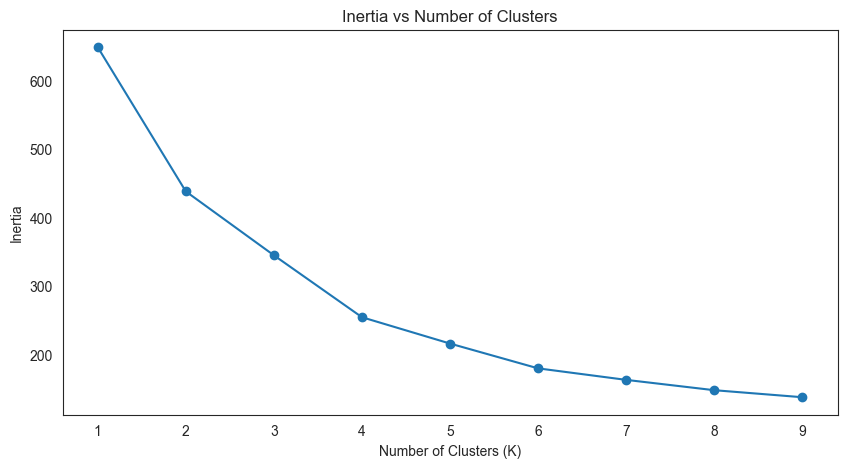

In [20]:
from sklearn.cluster import KMeans

# Generate inertia for k = 1 to k = 10
X = pd.DataFrame(new_df, columns=new_df.columns)
inertia = list()
list_clusters = range(1, 10)
for k in list_clusters:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10)
    kmeans.fit(X)
    inertia.append([k, kmeans.inertia_])
    
in_results = pd.DataFrame(inertia, columns=['K', 'Inertia'])

# Visualization of inertia vs k
plt.figure(figsize=(10,5))
plt.plot(in_results['K'], in_results['Inertia'], marker='o')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')

##### With the elbow method, we are going to select the k value where the decrease in the inertia stabilizes.
##### At k=4, the descent stabilizes and continues linearly afterwards, forming an elbow at k=4. This points out the optimal number of customer group is 4.

<span style="font-size:20px; color:#339; font-weight:bold">Clustering Evaluation Metrics</span>

In clustering, we don't have any labeled data but just a set of features and the objective is to obtain high intra-cluster similarity and low inter-cluster similarity for those features.<br/>
Evaluating the performance of any clustering algorithm is not as easy as calculating the number of errors or finding precision or recall like in supervised learning. Here we evaluate the outcomes based on the similarities or dissimilarities between data points.<br/>
The clustering algorithm is only as good as your similarity measures.<br/>
We will use Silhouette Coefficient to evaluate performance of our clustering model.

<span style="font-size:18px; color:#339; font-weight:bold">Silhouette Coefficient</span>

Silhouette coefficient is used to measure the quality of the clusters by determine the degree of separation between clusters.<br/>
The coefficient ranges between -1 and 1.<br/>
+1 indicates that the data point is far away from the neighboring cluster and thus optimally positioned.<br/>
0 indicates that the distance between clusters is not significant.<br/>
-1 indicates that the data point is assigned to the wrong cluster.<br/>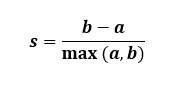<br/>
a = average distance between an instance (sample) and all other points within the same cluster or cluster cohesion<br/>
b = average distance between an instance (sample) and all other data points in the nearest cluster or cluster separation<br/>
The higher silhouette score indicates that the data points in the same cluster is more compact or have higher similarity and have better separation from other clusters.

Let's build the model with 4 clusters and calculate the silhouette score of the model we just built:

In [21]:
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=10)
kmeans.fit(X)

# Print the silhouette score for k=4
print('Silhouette Score: %.3f' % silhouette_score(X, kmeans.labels_, metric='euclidean'))

Silhouette Score: 0.350


The silhouette score of this model is about 0.35.

<span style="font-size:20px; color:#339; font-weight:bold">Visualize The Clusters</span>

We will visualize these cluster results from this model we just built and see how the quality of these cluster results is.

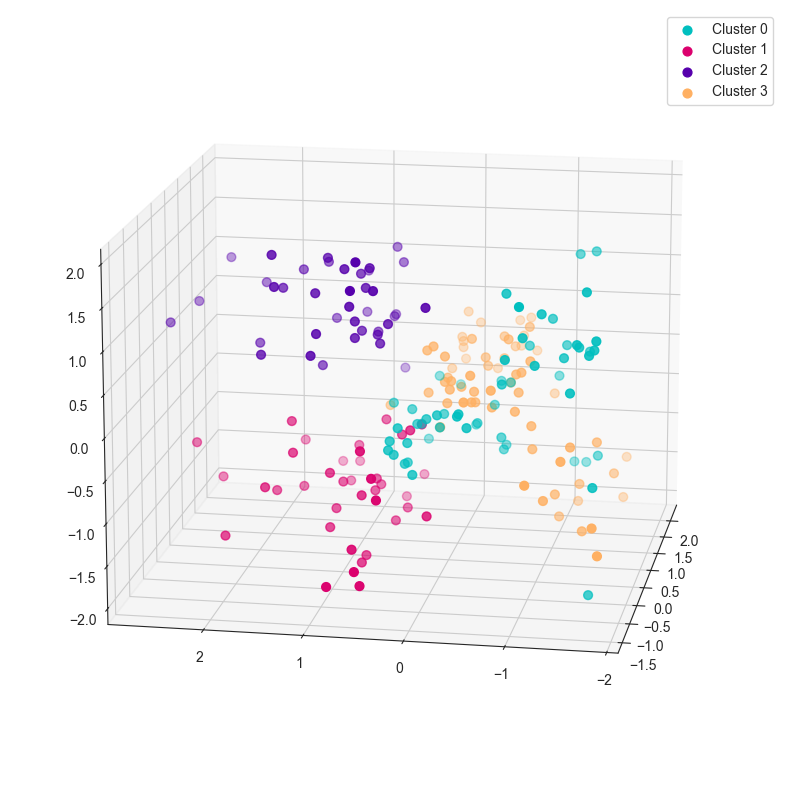

In [22]:
labels = kmeans.fit_predict(X)
new_df['Cluster'] = labels

# Visualize the clusters
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(new_df['Age'][new_df['Cluster'] == 0], new_df['Annual Income (k$)'][new_df['Cluster'] == 0], new_df['Spending Score (1-100)'][new_df['Cluster'] == 0], marker='o', s=40, color='#00BFBF', label='Cluster 0')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 1], new_df['Annual Income (k$)'][new_df['Cluster'] == 1], new_df['Spending Score (1-100)'][new_df['Cluster'] == 1], marker='o', s=40, color='#DB006D', label='Cluster 1')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 2], new_df['Annual Income (k$)'][new_df['Cluster'] == 2], new_df['Spending Score (1-100)'][new_df['Cluster'] == 2], marker='o', s=40, color='#5600AC', label='Cluster 2')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 3], new_df['Annual Income (k$)'][new_df['Cluster'] == 3], new_df['Spending Score (1-100)'][new_df['Cluster'] == 3], marker='o', s=40, color='#FFB062', label='Cluster 3')
ax.legend(loc=1)
ax.view_init(15, 190)
plt.show()

Let's we see the pairplot of numerical features to each cluster:

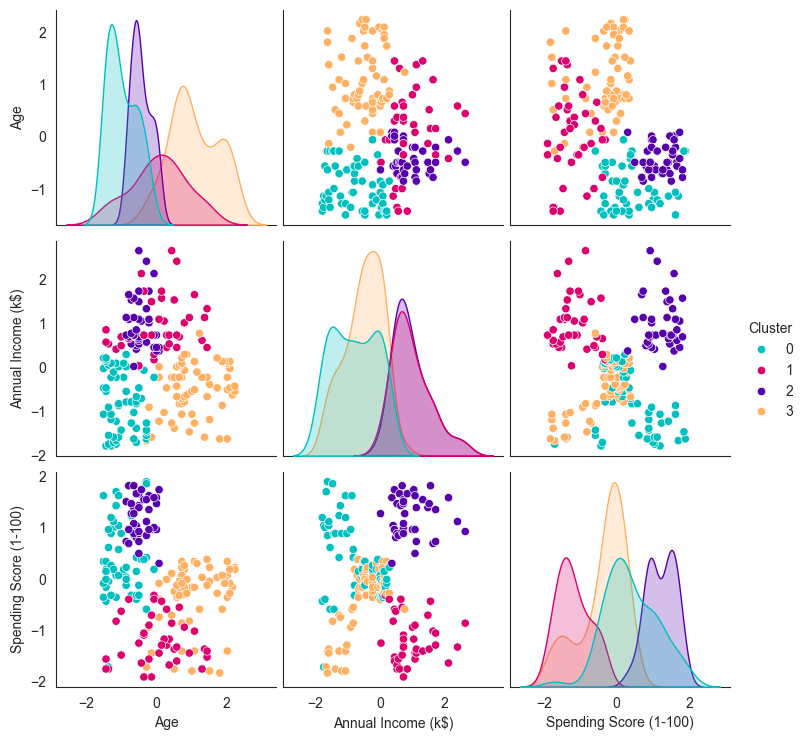

In [23]:
# Pairplot of numerical features
target_colors = dict({0:'#00BFBF', 1:'#DB006D', 2:'#5600AC', 3:'#FFB062'})
clusters1_df = pd.DataFrame(new_df, columns=['Age','Annual Income (k$)','Spending Score (1-100)','Cluster'])
sns.pairplot(clusters1_df, hue='Cluster', palette=target_colors)

We can see from the above 3D chart that the pink points are overlapping the oranges and the purple points overlapping the oranges.<br/>
And, we can see from the above pairplot that cluster separation is not too good.<br/>
We will try to create a new model to get better cluster separation with a higher silhouette score than this model.<br/>

## Building Clustering Model Using Principal Component Analysis (PCA)
---

<span style="font-size:20px; color:#339; font-weight:bold">Visualize the Explained Variances</span>

Principal Component Analysis is an algorithm to reduce the dimensionality of data. It creates new features or axes called principal components by projecting the original features to these new axes with maximum variance.<br/>
The explained variances add up to 1 if the number of these new axes is equal to the number of dimensions of the data, which means all these new features together explain 100% of the variance in the data.<br/>
We can reduce the number of features by selecting principal components that explain most of the variance in the data.<br/>
We will run PCA on the dataset and visualize the variance of each principal component:

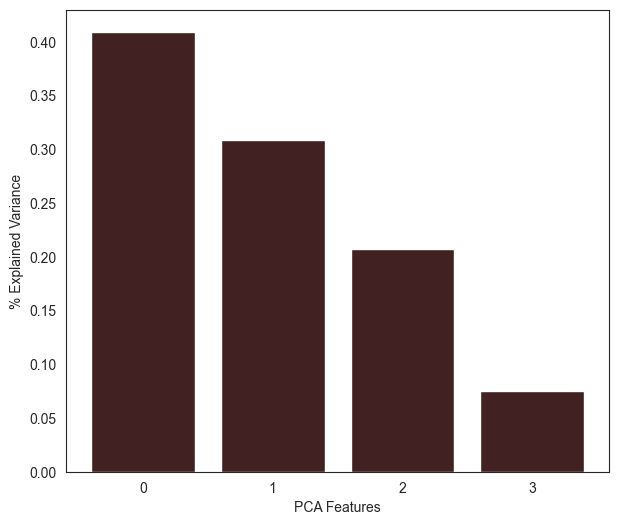

In [24]:
new_df = new_df.drop(['Cluster'], axis=1)
pca = PCA(n_components=4)
pca.fit(new_df)

features = range(pca.n_components_)
plt.figure(figsize=(7,6))
plt.bar(features, pca.explained_variance_ratio_, color='#412121')
plt.xlabel('PCA Features')
plt.ylabel('% Explained Variance')
plt.xticks(features)

PCA_components = pd.DataFrame(pca.transform(new_df))

Let's take a look at the value of the explained variance of each PCA component:

In [25]:
pca.explained_variance_ratio_

array([0.40933818, 0.30817842, 0.20714238, 0.07534102])

##### Based on this visualization, we can see that the first two PCA features explain the majority of the variance in our data (about 72%).
##### So, reduce the number of features to two PCA features.

<span style="font-size:18px; color:#339; font-weight:bold">Elbow Method</span>

Text(0, 0.5, 'Inertia')

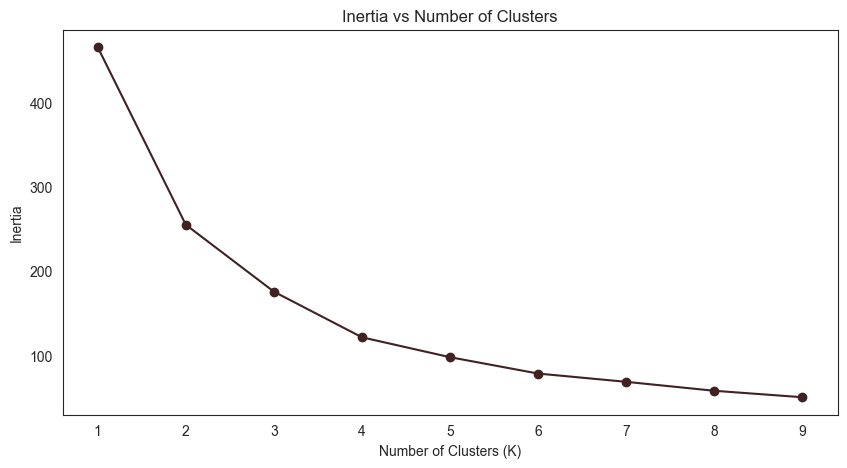

In [26]:
# Generate inertia for k = 1 to k = 10
inertia = list()
list_clusters = range(1, 10)
for k in list_clusters:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10)
    model.fit(PCA_components.iloc[:,:2])
    inertia.append([k, model.inertia_])
    
in_results = pd.DataFrame(inertia, columns=['K', 'Inertia'])

# Visualization of inertia vs k
plt.figure(figsize=(10,5))
plt.plot(in_results['K'], in_results['Inertia'], marker='o', color='#412121')
plt.title('Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')

##### Same as before, it shows an elbow at k=4, the optimal number of clusters is 4.
##### We can calculate the silhouette score for this model with 4 clusters.

<span style="font-size:20px; color:#339; font-weight:bold">Clustering Evaluation Metrics</span>

<span style="font-size:18px; color:#339; font-weight:bold">Silhouette Coefficient</span>

We calculate the silhouette score for this clustering model using PCA with 4 clusters:

In [27]:
model = KMeans(n_clusters=4, init='k-means++', n_init=10)
model.fit(PCA_components.iloc[:,:2])

# Print the silhouette score
print('Silhouette Score: %.3f' % silhouette_score(PCA_components.iloc[:,:2], model.labels_, metric='euclidean'))

Silhouette Score: 0.405


The silhouette score of this model is 0.406, which is better than the previous model we created.

<span style="font-size:20px; color:#339; font-weight:bold">Visualize The Clusters Using PCA Features</span>

We can visualize the clusters of this model using the two PCA Features that we use to build the model:

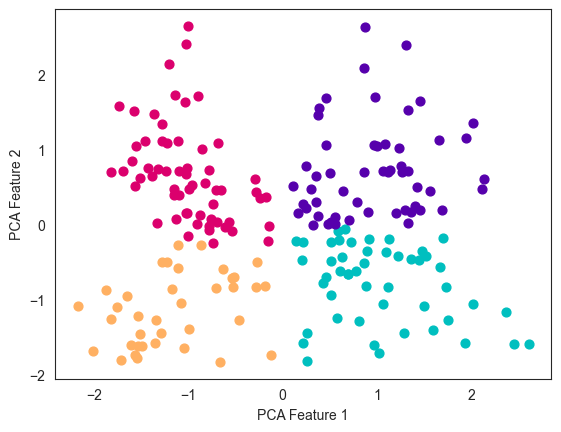

In [28]:
model = KMeans(n_clusters=4, init='k-means++', n_init=10)
labels = model.fit_predict(PCA_components.iloc[:,:2])

plt.scatter(PCA_components.iloc[:,0][labels == 0], PCA_components.iloc[:,1][labels == 0], marker='o', s=40, color='#00BFBF', label='Cluster 0')
plt.scatter(PCA_components.iloc[:,0][labels == 1], PCA_components.iloc[:,1][labels == 1], marker='o', s=40, color='#DB006D', label='Cluster 1')
plt.scatter(PCA_components.iloc[:,0][labels == 2], PCA_components.iloc[:,1][labels == 2], marker='o', s=40, color='#5600AC', label='Cluster 2')
plt.scatter(PCA_components.iloc[:,0][labels == 3], PCA_components.iloc[:,1][labels == 3], marker='o', s=40, color='#FFB062', label='Cluster 3')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.show()

<span style="font-size:20px; color:#339; font-weight:bold">Visualize The Clusters Using Original Features</span>

We will visualize these cluster results from this new model using original features and compare the quality of these cluster results with the previous model.

We can visualize the clusters of the new model using PCA to its original features:

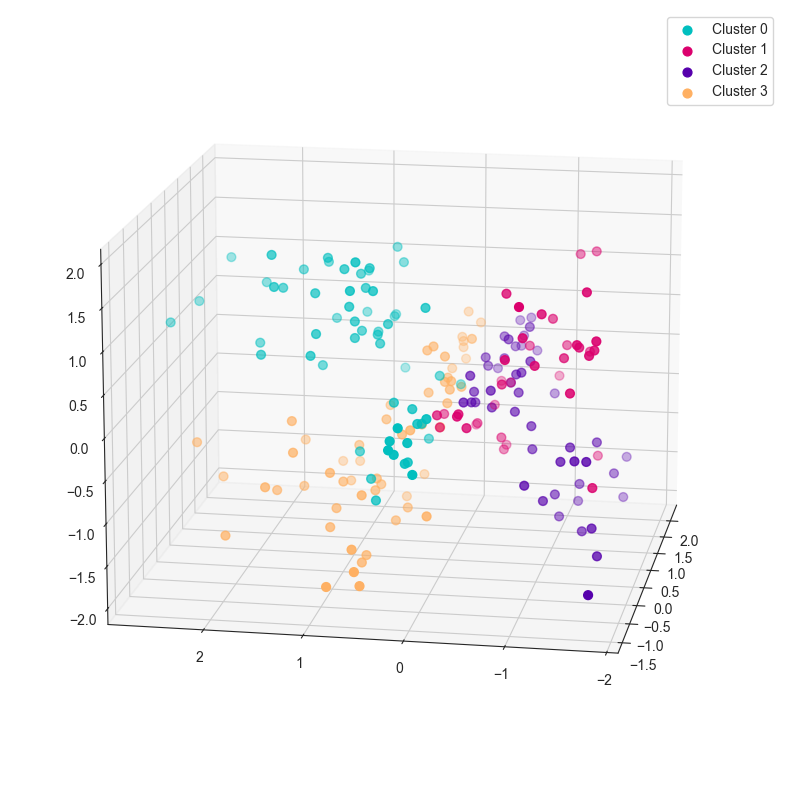

In [29]:
model = KMeans(n_clusters=4, init='k-means++', n_init=10)
labels = model.fit_predict(PCA_components.iloc[:,:2])
new_df['Cluster'] = labels

# Visualize the clusters
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection='3d')

ax.scatter3D(new_df['Age'][new_df['Cluster'] == 0], new_df['Annual Income (k$)'][new_df['Cluster'] == 0], new_df['Spending Score (1-100)'][new_df['Cluster'] == 0], marker='o', s=40, color='#00BFBF', label='Cluster 0')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 1], new_df['Annual Income (k$)'][new_df['Cluster'] == 1], new_df['Spending Score (1-100)'][new_df['Cluster'] == 1], marker='o', s=40, color='#DB006D', label='Cluster 1')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 2], new_df['Annual Income (k$)'][new_df['Cluster'] == 2], new_df['Spending Score (1-100)'][new_df['Cluster'] == 2], marker='o', s=40, color='#5600AC', label='Cluster 2')
ax.scatter3D(new_df['Age'][new_df['Cluster'] == 3], new_df['Annual Income (k$)'][new_df['Cluster'] == 3], new_df['Spending Score (1-100)'][new_df['Cluster'] == 3], marker='o', s=40, color='#FFB062', label='Cluster 3')
ax.legend(loc=1)
ax.view_init(15, 190)
plt.show()

Let's compare the cluster quality of this new model using PCA compared to the previous model with original features:

As we can see, the cluster separation in the new model using PCA is much better than the previous model with original features.<br/>
This is also indicated by a much higher silhouette score.<br/>
So, we will use the new model using PCA for our customer segmentation and perform cluster analysis.<br/>

Let's we see the pair plot of numerical features to each cluster of the new model:

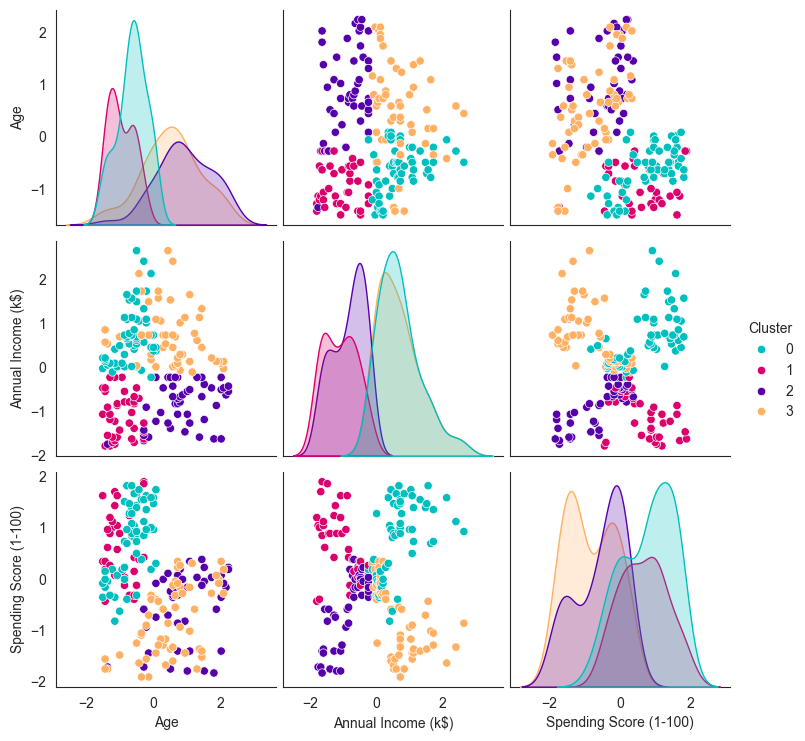

In [30]:
# Pairplot of numerical features
clusters2_df = pd.DataFrame(new_df, columns=['Age','Annual Income (k$)','Spending Score (1-100)','Cluster'])
sns.pairplot(clusters2_df, hue='Cluster', palette=target_colors)

And also, we can see from the above pair plot that the cluster separation of the new model is much better than the previous model.

## Cluster Analysis
---

<span style="font-size:20px; color:#339; font-weight:bold">Distribution of Clusters</span>

To perform cluster analysis, we use the cleaned dataset that we have stored before.<br/>
First, we need to save the cluster results back to the cleaned dataset.<br/>
Let's see the distribution of each cluster and visualize them:

ValueError: The palette dictionary is missing keys: {56, 59, 38, 47}

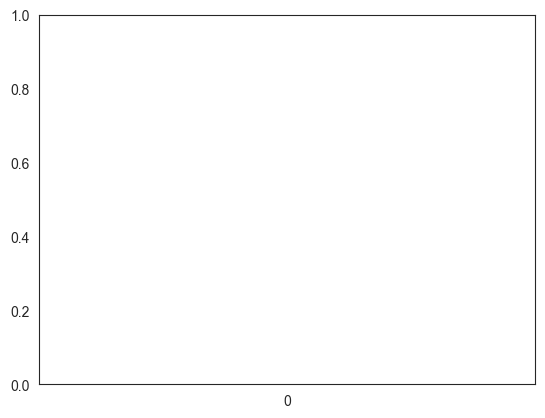

In [33]:
# Save the cluster results back to the cleaned dataset
cleaned_data['Cluster'] = new_df['Cluster']

# Distribution of Clusters
clusters = cleaned_data.groupby('Cluster').agg({'Cluster':'count'}).rename({'Cluster': 'Total'}, axis = 1)
clusters = clusters.sort_values(['Cluster'], ascending = (True)).reset_index()

ax = sns.barplot(data=clusters, x='Cluster', y='Total', hue='Total', palette=target_colors)
ax.set_title('Distribution of Clusters', fontfamily='serif', fontsize=12, fontweight='bold')
cleaned_data.groupby('Cluster')['Cluster'].count()

We can see here the distribution of each cluster:<br/>
Number of customers in Cluster 0 is 54 customers, Cluster 1 with 38 customers, Cluster 2 with 49 customers, and Cluster 3 with 59 customers.

<span style="font-size:20px; color:#339; font-weight:bold">Visualize Interpretation of Cluster Results</span>

We use visualization to interpret the cluster results more easily to understand in outline.<br/>
For summarizing data, we use mean for all variables. Let's calculate the mean of all numeric variables in each cluster:

In [ ]:
# Get mean of each numeric variables
avg_df = cleaned_data.groupby(['Cluster'], as_index=False).mean(numeric_only=True)
avg_df

##### Now, let's visualize the results with different plots for each numeric variable:

In [ ]:
features = ['Age','Annual Income (k$)','Spending Score (1-100)']

fig, axs = plt.subplots(3, 1, figsize=(6, 16))
for i in range(0,len(features)):   
    ax = sns.barplot(data=avg_df, x='Cluster', y=features[i], palette=target_colors, ax=axs[i])
    ax.set_title('Average '+features[i]+' of Each Cluster', fontfamily='serif', fontsize=12, fontweight='bold') 

##### Visualize the 'Gender' distribution of each cluster with this code:

In [ ]:
# Distribution of Gender
gd_data = cleaned_data.groupby(['Cluster','Gender']).agg({'Gender':'count'}).rename({'Gender': 'Total'}, axis = 1)
gd_data = gd_data.sort_values(['Cluster'], ascending = (True)).reset_index()
sns.set(rc = {'figure.figsize': (6, 5), 'axes.facecolor':'white'})
ax = sns.barplot(data=gd_data, x='Gender', y='Total', hue='Cluster', palette=target_colors)
ax.set_title('Distribution of Gender', fontfamily='serif', fontsize=12, fontweight='bold')

<span style="font-size:20px; color:#339; font-weight:bold">Convert Interpretation of Cluster Results in Statistical Numbers into a Table</span>

We will interpret the cluster results in statistical summary numbers into a table using the following code:

In [ ]:
# Numerical features distribution
cluster_results = pd.pivot_table(cleaned_data, values=['Age','Annual Income (k$)','Spending Score (1-100)'], index=['Cluster'],
                    aggfunc={'Age': [np.min, np.max, np.mean], 'Annual Income (k$)': [np.min, np.max, np.mean], 'Spending Score (1-100)': [np.min, np.max, np.mean]})

# Gender distribution
gender_count = cleaned_data.groupby(['Cluster','Gender']).agg({'Gender':'count'}).rename({'Gender': 'Total'}, axis = 1)
gender_pivot = np.round(pd.pivot_table(gender_count, values='Total', index='Cluster', columns='Gender', aggfunc=np.mean),0)
cluster_results['Gender_Female'] = gender_pivot['Female']
cluster_results['Gender_Male'] = gender_pivot['Male']
cluster_results

## Cluster Characteristics

#### Cluster 0
- Highest average annual income: ranges from 59–137 and an average of 79.3; lowest spending score.
- Age ranges from 19–68 with an average of around 46, and gender is predominantly male.<br/>
##### Customers in this group are frugal buyers, with an average age of more than 45.

#### Cluster 1
- Lowest average annual income: ranges from 15–54 and an average of 32.6; medium high spending score.
- Age ranges from 18–35 with an average of around 26, and gender is predominantly female.

##### Customers in this group are careless buyers, with the youngest average age above 25.

#### Cluster 2
- Medium average annual income: ranges from 16–58 and an average of 39.7; medium spending score.
- Age ranges from 20–70 with an average of around 52, and gender is predominantly female.

##### Customers in this group are cautious buyers, with the oldest average age above 50.

#### Cluster 3
- Medium high average annual income: ranges from 54–137 and an average of 78.6; highest spending score.
- Age ranges from 18–40 with an average of around 30, and gender is predominantly female.

##### Customers in this group are the most potential buyers who make the highest purchases, with the middled average age above 30.

## Conclusion

In this project, I walked through the complete machine learning process to build a K-Means clustering model for customer segmentation. I've successfully built a K-Means++ clustering algorithm using PCA to create better customer segments with the complete process, including how to detect and handle outliers, evaluate the performance of our model, and finally interpret the cluster results.<br/>
I've interpreted the cluster results through visualization and converted them in statistical numbers into a table, and also analyzed the cluster characteristics.

<br/>
<span style="color: #191970; font-size: 16px; font-weight:bold;">Created by: Felice Benita</span>